In [1]:
import datetime

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as aet #pt
from scipy.special import expit as logistic
import arviz as az

from itertools import product
import datetime as dt
from tqdm import tqdm
import seaborn as sns
sns.set_style("whitegrid")

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p)-np.log(1-p)

In [2]:
president_polls_url = 'https://projects.fivethirtyeight.com/polls/data/president_polls.csv'
df = pd.read_csv(president_polls_url)
df.to_csv("../Data/raw/president_polls.csv")

In [3]:
df = pd.read_csv("../Data/raw/president_polls.csv")

df_state = pd.read_csv("../Data/clean/state_code.csv")

df.loc[df['party'].isin(['REP', 'DEM']) == False, 'party'] = 'OTH'
#df.loc[(df['party'].isin(['REP', 'DEM']) == False) & (df['answer'] != 'Kennedy'), 'party'] = 'OTH'
df = df[df['party'] != 'OTH']

In [4]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/3015971515.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/3015971515.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


In [5]:
df['median_date'] = df['start_date'] + (df['end_date'] - df['start_date']) / 2
df.median_date = df.median_date.dt.round('D')

In [6]:
df['date'] = df.median_date
#df['date'] = df.end_date
#df = df[df['date'] >= '2023-11-05'] #Only polls since one year before election
df['week'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days // 7
df['day'] = (df['date'] - pd.Timestamp('2024-11-05')).dt.days

df = df.merge(df_state[['state','state_code']], how='left')
df.fillna({'state_code':"US"}, inplace=True)
df['state'] = df['state_code']

df = df.set_index('date')
df = df[["poll_id", "question_id", "pollster_id", "pollster", "methodology", "state", 'population', 'sample_size', 'cycle', 'election_date', 'week', 'day', 'party', 'answer',
       'candidate_id', 'candidate_name', 'pct']]

In [7]:
df['year'] = df.index.year
df['month'] = df.index.month

df = df.dropna()

In [8]:
df2 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Kamala Harris'})

df_count = df2.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df2.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way = df_polls.merge(df_count)
df_2way = df_2way.rename(columns={'REP':'GOP'})
df_2way['type'] = '2way'
df_2way = df_2way[df_2way['date'] >= '2024-07-21'] 

#df_2way['sample_size'] = round(df_2way['sample_size'] * (df_2way['DEM'] + df_2way['GOP'])/100)
df_2way[['DEM', 'GOP']] = df_2way[['DEM', 'GOP']].div(100)

In [9]:
df3 = df.groupby(['poll_id','question_id']).filter(lambda x: set(x['candidate_name']) == {'Donald Trump', 'Joe Biden'})

df_count = df3.pivot(index=['poll_id', 'question_id'], columns='party', values='pct').reset_index()
df_polls = df3.reset_index()[['poll_id', 'question_id', 'pollster_id', 'pollster', 'methodology',
       'state', 'population', 'sample_size', 'cycle', 'election_date','date', 'year', 'month', 'day', 'week']].drop_duplicates()

df_2way_jb = df_polls.merge(df_count)
df_2way_jb = df_2way_jb.rename(columns={'REP':'GOP'})
df_2way_jb['type'] = '2way'
df_2way_jb = df_2way_jb[df_2way_jb['date'] < '2024-07-21'] 

#df_2way_jb['sample_size'] = round(df_2way_jb['sample_size'] * (df_2way_jb['DEM'] + df_2way_jb['GOP'])/100)
df_2way_jb[['DEM', 'GOP']] = df_2way_jb[['DEM', 'GOP']].div(100)

In [10]:
df = pd.concat([df_2way, df_2way_jb])
df.dropna()
df['obs_id'] = range(len(df))
df['OTHER'] = 1 - (df['DEM'] + df['GOP'])

<Axes: >

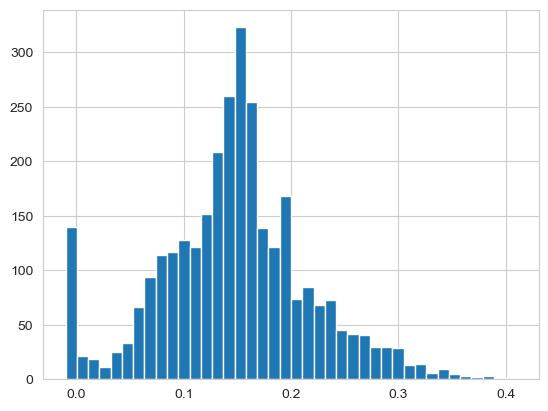

In [11]:
df.OTHER.hist(bins=40)

In [12]:
df = df.query("OTHER > 0")

Two way Biden vs Trump, Biden loses by 0.3%. Kamala loses by 4.8%. This is because Kamala's polling occured more after the race moved in Trump's favor.

In [13]:
df_2way.query("state == 'US'")[['DEM', 'GOP']].describe()

,DEM,GOP
count,34.000000,34.000000
mean,0.438941,0.446000
std,0.034076,0.040542
min,0.370000,0.340000
25%,0.420000,0.420000
50%,0.440000,0.450000
75%,0.460000,0.470000
max,0.495000,0.510000


In [14]:
df_2way_jb.query("state == 'US'")[['DEM', 'GOP']].describe()

,DEM,GOP
count,1775.000000,1775.000000
mean,0.420045,0.427253
std,0.037668,0.036258
min,0.290000,0.280000
25%,0.400000,0.410000
50%,0.430000,0.430000
75%,0.440000,0.440000
max,0.530000,0.540000


In [15]:
POLLSTERS = df['pollster'].sort_values().unique()
POLLSTERS_top = df.groupby('pollster').size().sort_values(ascending=False).head(10).index.values

METHODS = df['methodology'].sort_values().unique()
METHODS_top = df.groupby('methodology').size().sort_values(ascending=False).head(10).index.values

STATES = df['state'].sort_values().unique()
STATES_top = df.groupby('state').size().sort_values(ascending=False).head(10).index.values

POPULATIONS = df['population'].sort_values().unique()
POPULATIONS_top = df.groupby('population').size().sort_values(ascending=False).head(10).index.values

There have been polls since Spring 2019, and increased exponentially through election day.

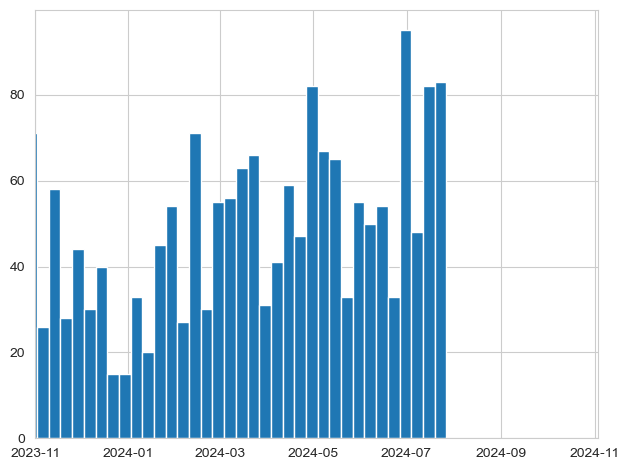

In [16]:
fig, ax = plt.subplots()
df.reset_index()["date"].hist(bins=len(df['week'].unique()), ax=ax)
ax.set_xlim(dt.datetime(2023, 11, 1), dt.datetime(2024, 11, 3))

plt.tight_layout()
plt.show()

In [17]:
# Create the cross-tabulation
cross_tab = pd.crosstab(df['pollster'], df['methodology'], margins=True)

# Extract 'All' row and 'All' column
all_row = cross_tab.loc['All']
all_col = cross_tab['All']

# Sort rows by 'All' column values (excluding the 'All' row)
sorted_rows = all_col.index[all_col.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_rows)

# Sort columns by 'All' row values (excluding the 'All' column)
sorted_columns = all_row.index[all_row.argsort()[::-1]]
cross_tab = cross_tab.reindex(sorted_columns, axis=1)

cross_tab.iloc[:11, :11]

methodology,All,Online Panel,Live Phone,Live Phone/Text-to-Web,IVR/Online Panel,Probability Panel,IVR/Online Panel/Text-to-Web,Online Panel/Text-to-Web,Online Panel/Text-to-Web/Text,IVR/Text-to-Web,Live Phone/Online Panel
pollster,,,,,,,,,,,
All,2949,1613,288,141,126,126,85,60,51,51,50
Morning Consult,725,725,0,0,0,0,0,0,0,0,0
Emerson,236,0,0,0,48,0,79,1,0,2,0
YouGov,191,191,0,0,0,0,0,0,0,0,0
Redfield & Wilton Strategies,168,168,0,0,0,0,0,0,0,0,0
Echelon Insights,103,96,0,7,0,0,0,0,0,0,0
Florida Atlantic University/Mainstreet Research,88,0,0,0,48,0,0,0,0,34,0
Siena/NYT,82,0,82,0,0,0,0,0,0,0,0
Ipsos,72,0,0,0,0,72,0,0,0,0,0


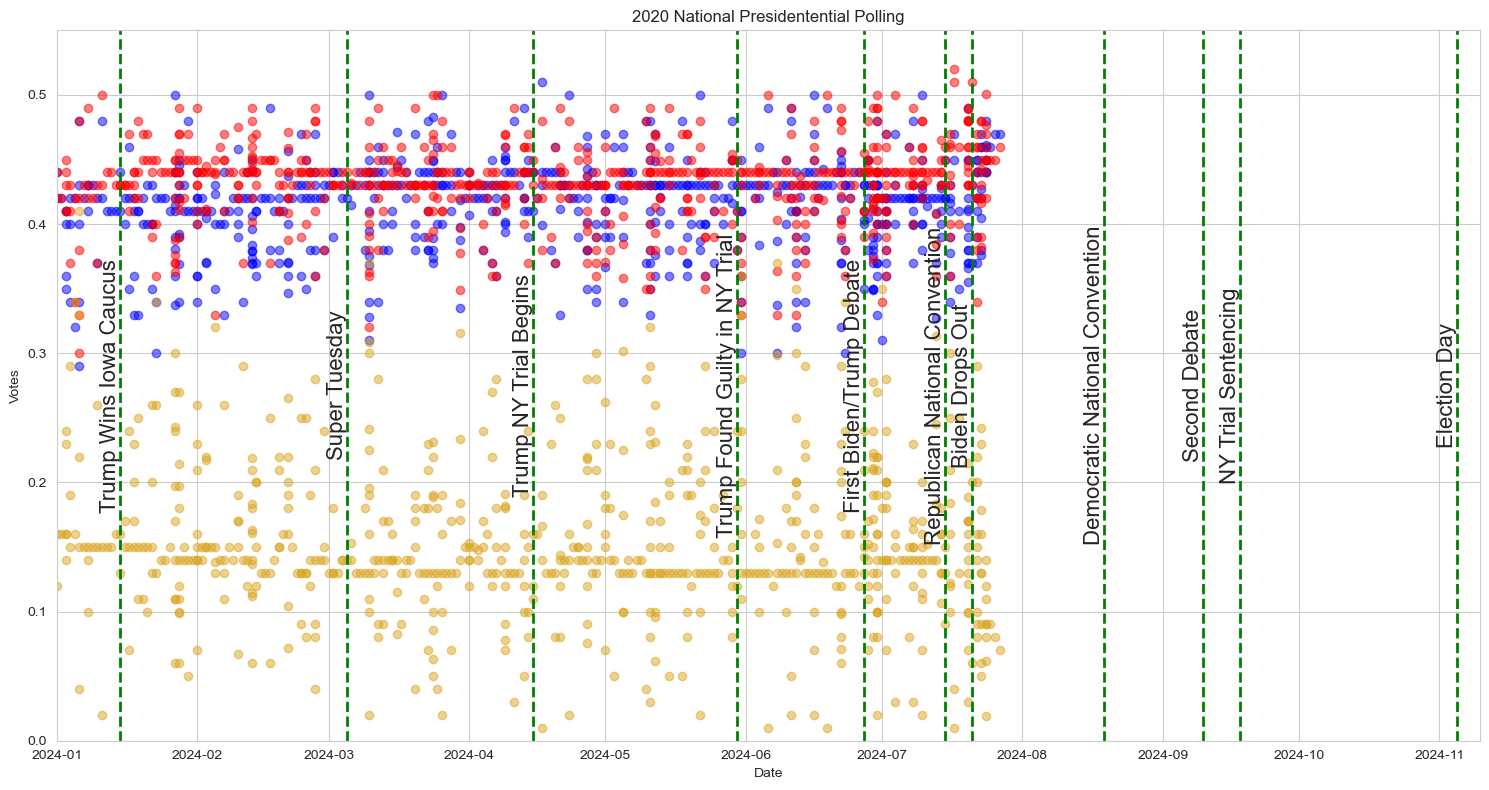

In [18]:
dem_votes = df.query("state == 'US'")["DEM"].values
gop_votes = df.query("state == 'US'")["GOP"].values
oth_votes = df.query("state == 'US'")["OTHER"].values

dates = df.query("state == 'US'").set_index('date').index

fig, ax = plt.subplots(figsize=(15, 8))

# Plotting dem_votes and gop_votes on the same axes
ax.plot(dates, dem_votes, "o", alpha=0.5, color='blue', label="Biden")
ax.plot(dates, gop_votes, "o", alpha=0.5, color='red', label="Trump")
ax.plot(dates, oth_votes, "o", alpha=0.5, color='goldenrod', label="Other")

# Set limits and labels
ax.set_ylim(0, 0.55)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 10))
ax.set_ylabel('Votes')
ax.set_xlabel('Date')
ax.set_title('2020 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'Trump Wins Iowa Caucus'),
            (dt.datetime(2024, 3, 5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Found Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Biden/Trump Debate'),
            (dt.datetime(2024, 7, 15), 'Republican National Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 19), 'Democratic National Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.275, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=16)


plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Daily standard deviation in polls')

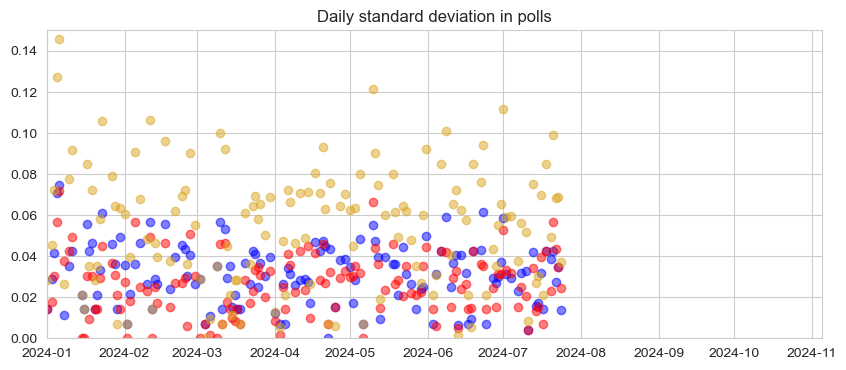

In [19]:
rolling_std = (
    df.query("state == 'US'")[["date", "DEM", "GOP", "OTHER"]]
    .reset_index()
    .groupby(["date"])
    .std()
    .reset_index()[["date", "DEM", "GOP", "OTHER"]]
    .dropna()
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    rolling_std.date,
    rolling_std.DEM.values,
    "o",
    color = 'blue',
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.GOP.values,
    "o",
    color = 'red',
    alpha=0.5,
)
ax.plot(
    rolling_std.date,
    rolling_std.OTHER.values,
    "o",
    color = 'goldenrod',
    alpha=0.5,
)


ax.set_ylim(0, .15)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_title("Daily standard deviation in polls")

We can see here that polling methodology is irrelevant, they all perform about the same.

In [20]:
df.query("state == 'US'").query("methodology in ['Online Panel', 'Live Phone', 'Probability Panel', 'IVR/Online Panel', 'IVR/Text', 'Live Phone/Online Panel', 'Text-to-Web/Online Ad']")[['methodology','DEM','GOP']].groupby("methodology").mean()

,DEM,GOP
methodology,,
IVR/Online Panel,0.406075,0.444208
IVR/Text,0.475000,0.450000
Live Phone,0.427042,0.433958
Live Phone/Online Panel,0.456000,0.440000
Online Panel,0.419785,0.422959
Probability Panel,0.387027,0.389279
Text-to-Web/Online Ad,0.397500,0.425000


We can see that Trump fairly consistently out-performs on App Panel polls.

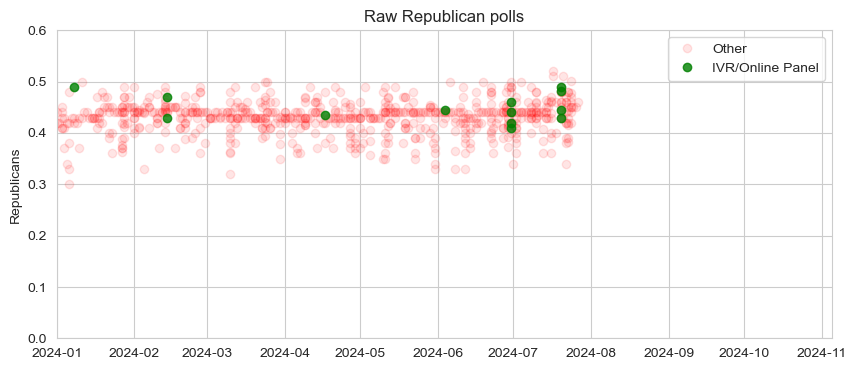

In [21]:
face = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == "IVR/Online Panel"]
face = face.set_index("date")
dates_face = face.index

other = df.query("state == 'US'")[df.query("state == 'US'")["methodology"] != "IVR/Online Panel"]
other = other.set_index("date")
dates_other = other.index

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dates_other, other["GOP"].values, "o", alpha=0.1, color = 'red', label="Other")
ax.plot(dates_face, face["GOP"].values, "o", alpha=.8, color = 'green', label="IVR/Online Panel")
ax.set_ylim(0, .6)
ax.set_ylabel("Republicans")
ax.set_title("Raw Republican polls")

ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.legend()

In [22]:
df["margin"] = df.apply(lambda row: (row['DEM'] - row['GOP']), axis=1)

df = (
    df.reset_index()
    .merge(
        df.groupby(["week","type"])[["GOP", "DEM", "margin"]].mean().reset_index(),
        on=["week","type"],
        suffixes=["", "_mean"],
    )
    .rename(columns={"index": "field_date"})
)

In [23]:
df["diff_GOP"] = df["GOP"] - df["GOP_mean"]
df["diff_DEM"] = df["DEM"] - df["DEM_mean"]

df["diff_margin"] = df["margin"] - df["margin_mean"]

df.round(2)

,field_date,poll_id,question_id,pollster_id,pollster,methodology,state,population,sample_size,cycle,...,type,obs_id,OTHER,margin,GOP_mean,DEM_mean,margin_mean,diff_GOP,diff_DEM,diff_margin
0,0,87597,204617,1189,Morning Consult,Online Panel,US,rv,11538.0,2024,...,2way,0,0.07,0.01,0.45,0.45,0.01,0.01,0.02,0.00
1,1,87598,204618,1189,Morning Consult,Online Panel,US,rv,4000.0,2024,...,2way,1,0.08,0.02,0.45,0.45,0.01,0.00,0.02,0.01
2,2,87577,204376,1878,SoCal Research,Online Panel,MI,rv,500.0,2024,...,2way,2,0.05,-0.03,0.45,0.45,0.01,0.04,0.01,-0.04
3,3,87588,204533,1878,SoCal Research,Online Panel,GA,rv,505.0,2024,...,2way,3,0.04,-0.04,0.45,0.45,0.01,0.05,0.01,-0.04
4,4,87599,204619,1189,Morning Consult,Online Panel,US,rv,4000.0,2024,...,2way,4,0.09,0.01,0.45,0.45,0.01,0.00,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2944,3013,74810,142358,568,YouGov,Online Panel,US,a,1561.0,2024,...,2way,3083,0.16,0.12,0.36,0.48,0.12,0.00,0.00,0.00
2945,3014,74928,142758,446,St. Anselm,Text-to-Web,NH,rv,1267.0,2024,...,2way,3084,0.06,0.08,0.43,0.51,0.08,0.00,0.00,0.00
2946,3015,74706,140769,1056,Remington,IVR,MO,lv,933.0,2024,...,2way,3085,0.09,-0.15,0.53,0.38,-0.15,0.00,0.00,0.00
2947,3016,74812,142390,241,Ipsos,Probability Panel,US,a,1105.0,2024,...,2way,3086,0.27,0.17,0.28,0.45,0.17,0.00,0.00,0.00


In [24]:
df.groupby('type')[['margin']].mean()

,margin
type,
2way,-0.01509


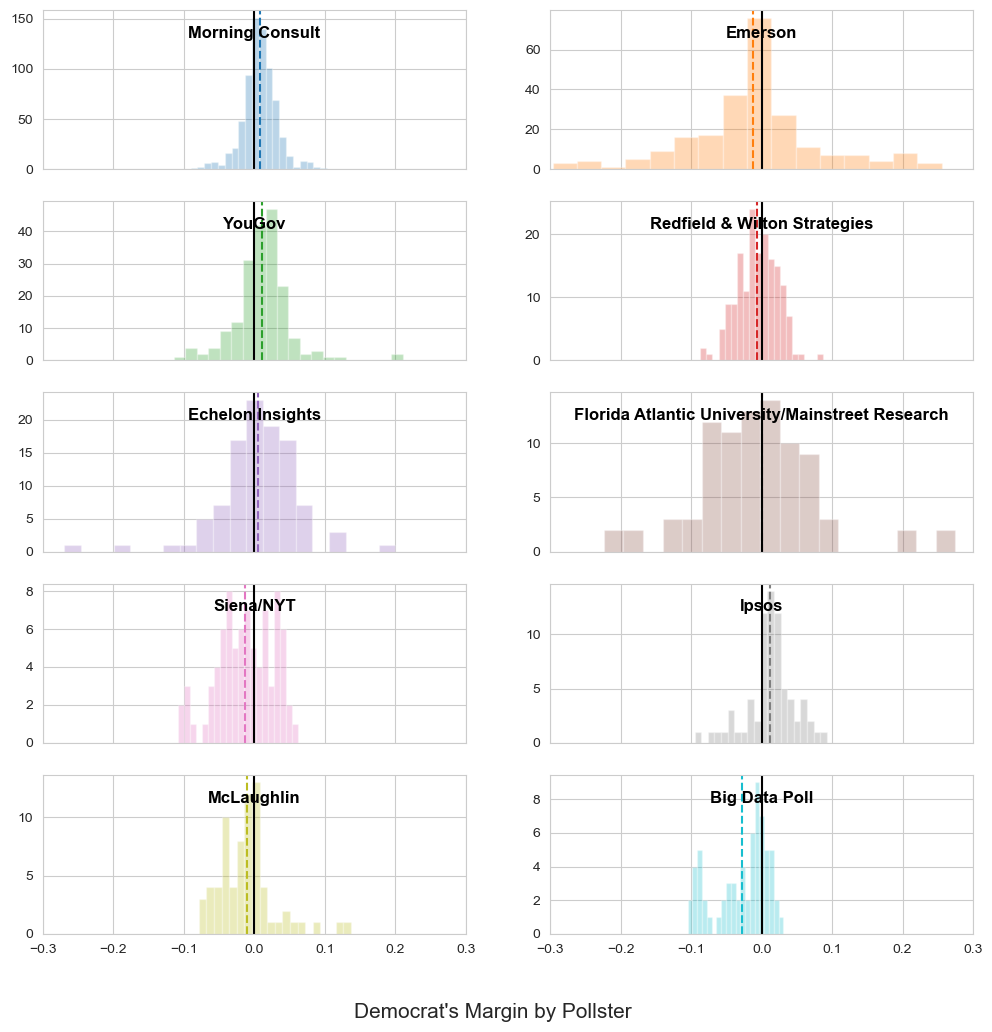

In [25]:
POLLSTER_VALS = {
    pollster: df[df["pollster"] == pollster]["diff_margin"].values
    for pollster in list(POLLSTERS_top)
}

# Get color cycle
colors = plt.rcParams["axes.prop_cycle"]()

# Create subplots
fig, axes = plt.subplots(ncols=2, nrows=5, sharex=True, figsize=(12, 12))

# Iterate over axes and pollster data
for ax, (pollster, vals) in zip(axes.ravel(), POLLSTER_VALS.items()):
    c = next(colors)["color"]  # Get the next color
    ax.hist(vals, bins=20, alpha=0.3, color=c, label=pollster)  # Plot histogram
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")  # Plot mean line
    ax.axvline(x=0, color="black")  # Plot vertical line at 0
    ax.set_xlim(-.3, .3)  # Set x-axis limits
    
    # Add pollster label text over the subplot
    ax.text(0.5, 0.9, pollster, color='black', fontsize=12, 
            ha='center', va='top', transform=ax.transAxes, weight='bold')
    
# Set the shared x-label
fig.text(0.5, 0.04, r"Democrat's Margin by Pollster", ha='center', fontsize=15)

# Show the plot
plt.show()

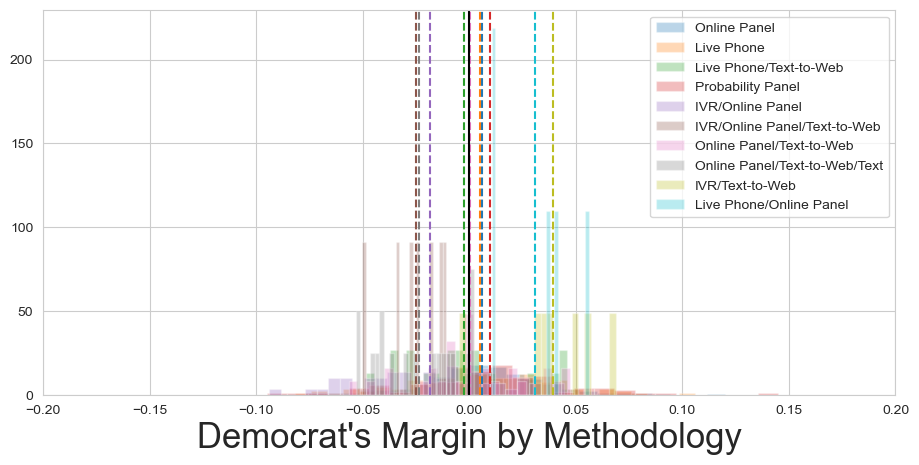

In [26]:
METHOD_VALS = {
    method: df.query("state == 'US'")[df.query("state == 'US'")["methodology"] == method]["diff_margin"].values
    for method in METHODS_top
}

colors = plt.rcParams["axes.prop_cycle"]()
fig, ax = plt.subplots(figsize=(11, 5))

for method, vals in METHOD_VALS.items():
    c = next(colors)["color"]
    ax.hist(vals, alpha=0.3, color=c, label=method, bins=25, density=True)
    ax.axvline(x=np.mean(vals), color=c, linestyle="--")

ax.axvline(x=0, color="black")
ax.set_xlim(-.2, .2)
ax.set_xlabel(r"Democrat's Margin by Methodology", fontsize=25)
ax.legend();

In [27]:
date_counts = df['date'].value_counts().reset_index()

# Rename the columns
date_counts.columns = ['date', 'count']

# Sort the DataFrame by date in descending order
date_counts = date_counts.sort_values(by='date', ascending=False).reset_index(drop=True)

print(date_counts)

          date  count
0   2024-07-27      1
1   2024-07-26      3
2   2024-07-25      1
3   2024-07-24     15
4   2024-07-23     27
..         ...    ...
755 2021-05-12      1
756 2021-05-09      1
757 2021-04-21      1
758 2021-04-14      1
759 2021-04-05      1

[760 rows x 2 columns]


In [28]:
#df = df[df['date'] >= '2024-05-01'] #Only polls since one year before election
#df = df[df['date'] < '2024-07-26'] #We only have two polls for the most recent date, we don't want that to bias the long-run rws

In [29]:
week_id, week = df.set_index(
    ["week"]
).index.factorize(sort=True)

day_id, day = df.set_index(
    ["day"]
).index.factorize(sort=True)
day = np.concatenate([day, np.arange(max(day)+1, 1)])

party_id, party = [0,1,2], ['DEM','GOP','Other']

week = np.arange(min(week), 1)

pollster_id, pollster = df.set_index(
    ["pollster"]
).index.factorize(sort=True)

method_id, method = df.set_index(
    ["methodology"]
).index.factorize(sort=True)

state_id, state = df.set_index(
    ["state"]
).index.factorize(sort=True)

population_id, population = df.set_index(
    ["population"]
).index.factorize(sort=True)

COORDS = {
    "pollster": pollster,
    "method": method,
    "state": state,
    "party": party,
    "population": population,
    "week": week,
    "day": day,
    "observation": df.obs_id
}

In [30]:
with pm.Model(coords=COORDS) as twoway:

    epsilon = 1e-6  # A small positive number for penalizing deviations

    dem_sigma       = pm.HalfNormal("dem_sigma", sigma=0.1) + epsilon
    dem_rho         = pm.Normal("dem_rho", mu=0, sigma=0.7)
    dem_ar          = pm.AR("dem_ar",
                            rho=[dem_rho] * 3,
                            sigma=dem_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    dem_sigma_rw    = pm.HalfNormal("dem_sigma_rw", sigma=0.1) + epsilon
    dem_random_walk = pm.GaussianRandomWalk("dem_random_walk",
                                            sigma=dem_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    dem_day_effect  = pm.Deterministic("dem_day_effect", dem_ar + dem_random_walk, dims="day")

    dem_pollster_effect = pm.Normal("dem_pollster_effect", 0, 0.2, dims="pollster")
    dem_method_effect   = pm.Normal("dem_method_effect", 0, 0.2, dims="method")
    dem_state_effect    = pm.Normal("dem_state_effect", 0, 0.2, dims="state")
    dem_state_multi     = pm.Normal("dem_state_multi", 1, 0.2, dims="state")
    dem_pop_effect      = pm.Normal("dem_pop_effect", 0, 0.2, dims="population")

    dem_polling = pm.Deterministic("dem_polling", pm.math.invlogit(
        dem_pollster_effect[pollster_id] +
        dem_method_effect[method_id] +
        dem_pop_effect[population_id] +
        dem_state_effect[state_id] +
        dem_state_multi[state_id] *
        dem_day_effect[day_id]
    ),
        dims = "observation")
    
    gop_sigma       = pm.HalfNormal("gop_sigma", sigma=0.1) + epsilon
    gop_rho         = pm.Normal("gop_rho", mu=0, sigma=0.7)
    gop_ar          = pm.AR("gop_ar",
                            rho=[gop_rho] * 3,
                            sigma=gop_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    gop_sigma_rw    = pm.HalfNormal("gop_sigma_rw", sigma=0.1) + epsilon
    gop_random_walk = pm.GaussianRandomWalk("gop_random_walk",
                                            sigma=gop_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    gop_day_effect  = pm.Deterministic("gop_day_effect", gop_ar + gop_random_walk, dims="day")

    gop_pollster_effect = pm.Normal("gop_pollster_effect", 0, 0.2, dims="pollster")
    gop_method_effect   = pm.Normal("gop_method_effect", 0, 0.2, dims="method")
    gop_state_effect    = pm.Normal("gop_state_effect", 0, 0.2, dims="state")
    gop_state_multi     = pm.Normal("gop_state_multi", 1, 0.2, dims="state")
    gop_pop_effect      = pm.Normal("gop_pop_effect", 0, 0.2, dims="population")

    gop_polling = pm.Deterministic("gop_polling", pm.math.invlogit(
        gop_pollster_effect[pollster_id] +
        gop_method_effect[method_id] +
        gop_pop_effect[population_id] +
        gop_state_effect[state_id] +
        gop_state_multi[state_id] *
        gop_day_effect[day_id]
    ),
        dims = "observation")

    oth_sigma       = pm.HalfNormal("oth_sigma", sigma=0.1) + epsilon
    oth_rho         = pm.Normal("oth_rho", mu=0, sigma=0.7)
    oth_ar          = pm.AR("oth_ar",
                            rho=[oth_rho] * 3,
                            sigma=oth_sigma,
                            init_dist=pm.Normal.dist(mu=0, sigma=0.05),
                            dims="day"
                           )
    oth_sigma_rw    = pm.HalfNormal("oth_sigma_rw", sigma=0.1) + epsilon
    oth_random_walk = pm.GaussianRandomWalk("oth_random_walk",
                                            sigma=oth_sigma_rw,
                                            init_dist=pm.Normal.dist(mu=0, sigma=0.3),
                                            dims="day")
    oth_day_effect  = pm.Deterministic("oth_day_effect", oth_ar + oth_random_walk, dims="day")

    oth_pollster_effect = pm.Normal("oth_pollster_effect", 0, 0.2, dims="pollster")
    oth_method_effect   = pm.Normal("oth_method_effect", 0, 0.2, dims="method")
    oth_state_effect    = pm.Normal("oth_state_effect", 0, 0.2, dims="state")
    oth_state_multi     = pm.Normal("oth_state_multi", 1, 0.2, dims="state")
    oth_pop_effect      = pm.Normal("oth_pop_effect", 0, 0.2, dims="population")

    oth_polling = pm.Deterministic("oth_polling", pm.math.invlogit(
        oth_pollster_effect[pollster_id] +
        oth_method_effect[method_id] +
        oth_pop_effect[population_id] +
        oth_state_effect[state_id] +
        oth_state_multi[state_id] *
        oth_day_effect[day_id]
    ),
        dims = "observation")

    # Binomial likelihoods
    dem_vote = pm.Binomial(
        "dem_vote",
        p = dem_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['DEM'],
        dims = "observation",
    )

    gop_vote = pm.Binomial(
        "gop_vote",
        p = gop_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['GOP'],
        dims = "observation",
    )

    oth_vote = pm.Binomial(
        "oth_vote",
        p = oth_polling,
        n = df["sample_size"],
        observed = df['sample_size'] * df['OTHER'],
        dims = "observation",
    )

    polling_error_dem = pm.Normal("polling_error_dem", 0, .1)
    polling_error_gop = pm.Normal("polling_error_gop", 0, .1)
    polling_error_oth = pm.Deterministic("polling_error_oth",-(polling_error_dem + polling_error_gop))

    # Sampling
    idata = pm.sample(draws=100, cores=10, return_inferencedata=True, step=pm.NUTS(target_accept=0.95), init='advi+adapt_diag')

Multiprocess sampling (10 chains in 10 jobs)
NUTS: [dem_sigma, dem_rho, dem_ar, dem_sigma_rw, dem_random_walk, dem_pollster_effect, dem_method_effect, dem_state_effect, dem_state_multi, dem_pop_effect, gop_sigma, gop_rho, gop_ar, gop_sigma_rw, gop_random_walk, gop_pollster_effect, gop_method_effect, gop_state_effect, gop_state_multi, gop_pop_effect, oth_sigma, oth_rho, oth_ar, oth_sigma_rw, oth_random_walk, oth_pollster_effect, oth_method_effect, oth_state_effect, oth_state_multi, oth_pop_effect, polling_error_dem, polling_error_gop]
/Users/awalters/opt/anaconda3/envs/oecd_project/lib/python3.12/site-packages/pytensor/compile/function/types.py:1138: UserWarning: aliased relationship between Function arguments 861, 861 will not be preserved by un-pickling operation
  warnings.warn(


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 1854 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


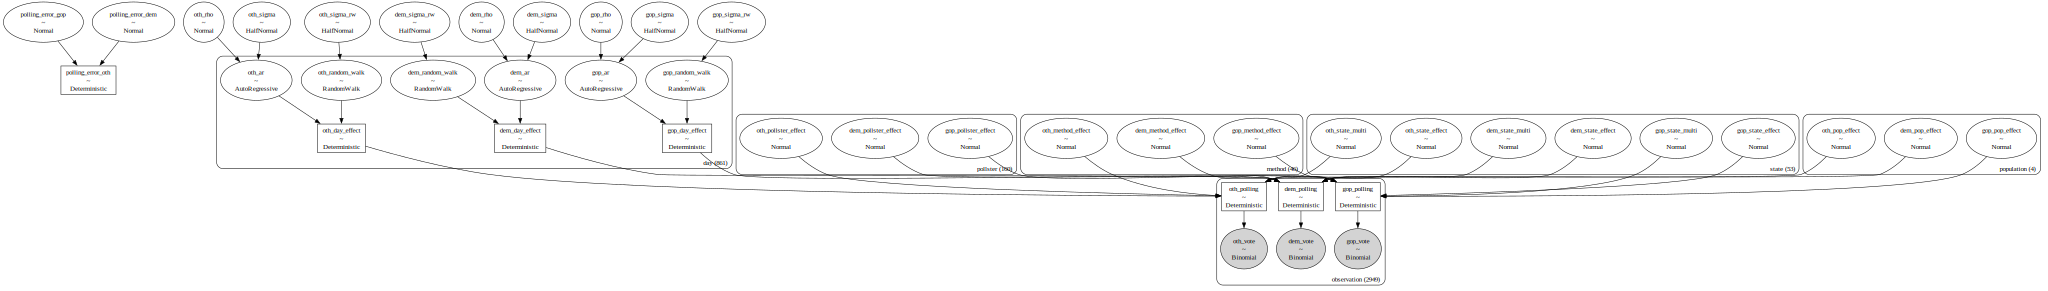

In [31]:
pm.model_to_graphviz(twoway)

In [32]:
z = pd.DataFrame()
z['state'] = idata.posterior.state
z['dem_state_multi'] = idata.posterior.dem_state_multi.mean(axis=0).mean(axis=0).values
z['dem_state_effect'] = idata.posterior.dem_state_effect.mean(axis=0).mean(axis=0).values
z['gop_state_multi'] = idata.posterior.gop_state_multi.mean(axis=0).mean(axis=0).values
z['gop_state_effect'] = idata.posterior.gop_state_effect.mean(axis=0).mean(axis=0).values
z['oth_state_multi'] = idata.posterior.oth_state_multi.mean(axis=0).mean(axis=0).values
z['oth_state_effect'] = idata.posterior.oth_state_effect.mean(axis=0).mean(axis=0).values

In [33]:
z.sort_values(by='state')

,state,dem_state_multi,dem_state_effect,gop_state_multi,gop_state_effect,oth_state_multi,oth_state_effect
0,AK,1.057649,-0.062687,1.004570,0.213159,1.341495,-0.032926
1,AL,1.044061,-0.296726,0.978971,0.389843,1.166627,-0.158665
2,AR,1.113829,-0.403661,0.983573,0.435947,1.078297,-0.097178
3,AZ,0.907878,0.046232,0.936837,-0.024326,0.832340,-0.234844
4,CA,1.532420,0.668608,1.402424,-0.517960,1.518013,0.132235
5,CO,0.598728,0.176450,1.195395,-0.243336,1.429570,0.249649
6,CT,0.949930,0.344814,1.038099,-0.314171,1.060200,-0.124118
7,FL,0.862814,-0.015862,0.951682,0.087481,0.627906,-0.477440
8,GA,0.927267,0.045664,1.036118,0.009366,0.838405,-0.287371
9,HI,0.912155,0.397973,1.010683,-0.292407,1.105903,-0.202353


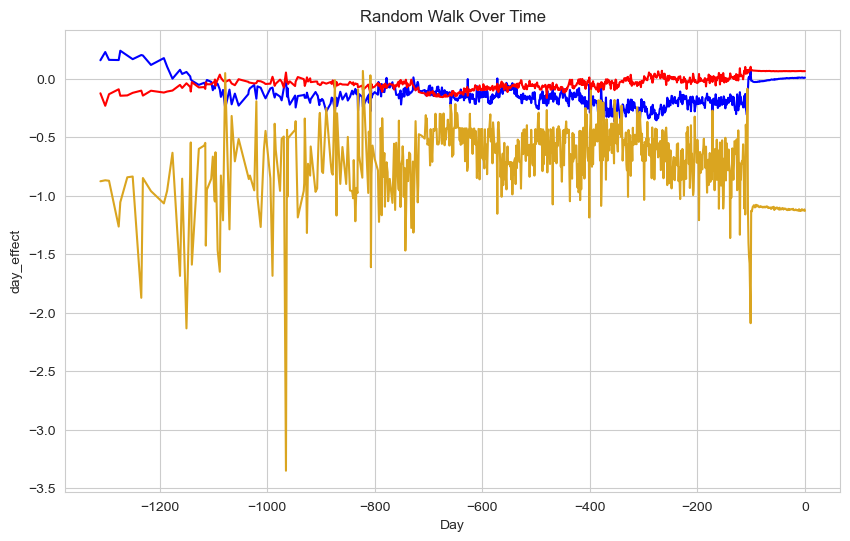

In [34]:
dem = pd.DataFrame()
dem['day'] = idata.posterior.day
dem['day_effect'] = idata.posterior.dem_day_effect.mean(axis=0).mean(axis=0).values

gop = pd.DataFrame()
gop['day'] = idata.posterior.day
gop['day_effect'] = idata.posterior.gop_day_effect.mean(axis=0).mean(axis=0).values

oth = pd.DataFrame()
oth['day'] = idata.posterior.day
oth['day_effect'] = idata.posterior.oth_day_effect.mean(axis=0).mean(axis=0).values

plt.figure(figsize=(10, 6))
plt.plot(dem['day'], dem['day_effect'], color='blue', label='Democrats', linestyle='-')
plt.plot(gop['day'], gop['day_effect'], color='red', label='Republicans', linestyle='-')
plt.plot(oth['day'], oth['day_effect'], color='goldenrod', label='Other', linestyle='-')
plt.xlabel('Day')
plt.ylabel('day_effect')
plt.title('Random Walk Over Time')
plt.grid(True)
plt.show()

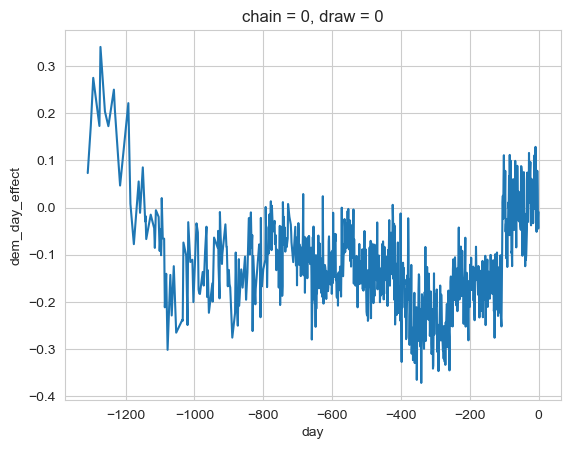

In [35]:
idata.posterior.dem_day_effect.sel(chain=0, draw=0).plot()

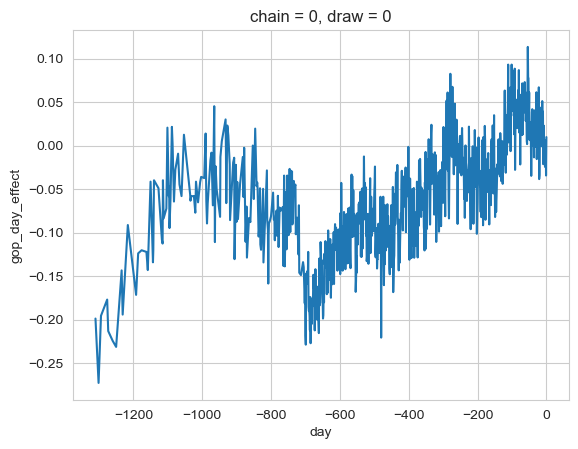

In [36]:
idata.posterior.gop_day_effect.sel(chain=0, draw=0).plot()

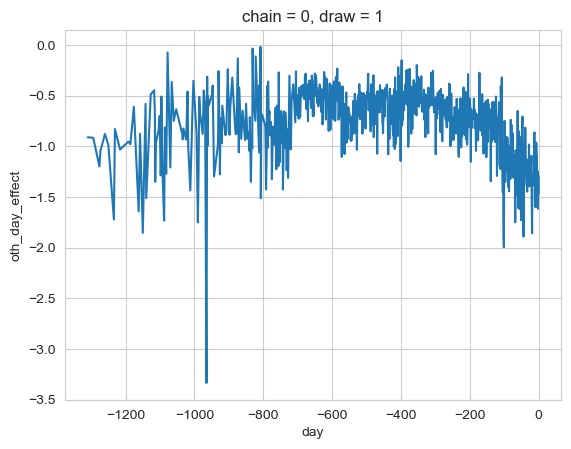

In [37]:
idata.posterior.oth_day_effect.sel(chain=0, draw=1).plot()

In [38]:
states = df['state'].unique()
parties = ['dem','gop','margin','oth']

combinations = [f"{state}_{party}" for state, party in product(states, parties)]

In [39]:
interim = pd.DataFrame()

for party in ['dem', 'gop', 'oth']:
    pollster_effects = (
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Ipsos") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="YouGov") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Emerson") +
        #idata.posterior[f"{party}_pollster_effect"].sel(pollster="Monmouth") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Quinnipiac") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Siena/NYT") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="ABC/Washington Post") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marist") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Marquette Law School") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="Suffolk") +
        idata.posterior[f"{party}_pollster_effect"].sel(pollster="U. Massachusetts - Lowell")
    ).values / 10
    pollster_effects_flat = pollster_effects.ravel()
    interim[f"pollster_effects_{party}"] = pollster_effects_flat

    method_effects = (
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Probability Panel', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'Live Phone/Online Panel', drop=True).mean(axis=2) +
        idata.posterior[f"{party}_method_effect"].where(idata.posterior[f"{party}_method_effect"].method == 'IVR/Live Phone/Text/Online Panel/Email', drop=True).mean(axis=2)
    )/4
    method_effects_flat = pollster_effects.ravel()
    interim[f"method_effects_{party}"] = pollster_effects_flat

    pop_effects = (
        idata.posterior[f"{party}_pop_effect"].sel(population="lv")
    ).values
    pop_effects_flat = pop_effects.ravel()
    interim[f"pop_effects_{party}"] = pop_effects_flat

    interim[f"polling_error_{party}"] = idata.posterior[f"polling_error_{party}"].values.ravel()

    interim[f"fund_{party}"] = interim[f"pollster_effects_{party}"] + interim[f"method_effects_{party}"] + interim[f"pop_effects_{party}"] + interim[f"polling_error_{party}"]

In [105]:
df_results = pd.DataFrame(columns=combinations)
df_day_mean = pd.DataFrame(index=day, columns=combinations)
df_day_03 =  pd.DataFrame(index=day, columns=combinations)
df_day_25 =  pd.DataFrame(index=day, columns=combinations)
df_day_75 =  pd.DataFrame(index=day, columns=combinations)
df_day_97 =  pd.DataFrame(index=day, columns=combinations)

#for d in tqdm(day):
for d in [-100]:
    for state in states:
        for party in ['dem','gop','oth']:
            df_results[f"{state}_{party}"] = inv_logit(
                interim[f"fund_{party}"] +
                idata.posterior[f"{party}_state_effect"].sel(state=f"{state}").values.ravel() +
                idata.posterior[f"{party}_state_multi"].sel(state=f"{state}").values.ravel() *
                idata.posterior[f"{party}_day_effect"].sel(day=d).values.ravel()
            ).values.ravel()
            
        state_columns = [f"{state}_dem", f"{state}_gop", f"{state}_oth"]
        df_results[f"{state}_dem"] = df_results[f"{state}_dem"] + df_results[f"{state}_oth"] / 4
        df_results[f"{state}_gop"] = df_results[f"{state}_gop"] + df_results[f"{state}_oth"] / 4
        df_results[f"{state}_oth"] = df_results[f"{state}_oth"] / 2
        df_results[f"{state}_total"] = df_results[state_columns].sum(axis=1)

        for col in state_columns:
            df_results[col] = df_results[col] / df_results[f"{state}_total"]
        
        df_results[f"{state}_margin"] = df_results[f"{state}_dem"] - df_results[f"{state}_gop"]

    df_day_03.loc[d] = df_results.quantile(0.03)
    df_day_25.loc[d] = df_results.quantile(0.25)
    df_day_mean.loc[d] = df_results.quantile(0.50)
    df_day_75.loc[d] = df_results.quantile(0.75)
    df_day_97.loc[d] = df_results.quantile(0.97)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/2696717534.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f"{state}_total"] = df_results[state_columns].sum(axis=1)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/2696717534.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results[f"{state}_total"] = df_results[state_columns].sum(axis=1)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/2696717534.py:23: PerformanceWarning: DataFrame is highly fragmented.  This 

<Axes: >

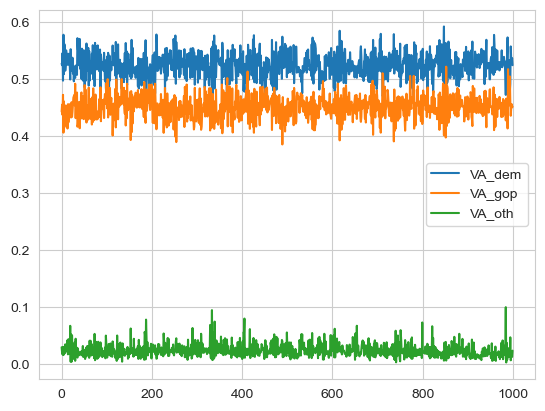

In [106]:
df_results[['VA_dem','VA_gop','VA_oth']].plot()

In [107]:
df.date

0      2024-07-27
1      2024-07-26
2      2024-07-26
3      2024-07-26
4      2024-07-25
          ...    
2944   2021-05-12
2945   2021-05-09
2946   2021-04-21
2947   2021-04-14
2948   2021-04-05
Name: date, Length: 2949, dtype: datetime64[ns]

In [108]:
pd.date_range(start=df.date.min(), end='2024-11-05')

DatetimeIndex(['2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
               '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12',
               '2021-04-13', '2021-04-14',
               ...
               '2024-10-27', '2024-10-28', '2024-10-29', '2024-10-30',
               '2024-10-31', '2024-11-01', '2024-11-02', '2024-11-03',
               '2024-11-04', '2024-11-05'],
              dtype='datetime64[ns]', length=1311, freq='D')

In [109]:
date_index = pd.DataFrame(index = range(min(df_day_mean.index),1), columns = ['date'])
date_index['date'] = pd.date_range(start=df.date.min(), end='2024-11-05')
df_day_mean = df_day_mean.merge(date_index, left_index=True, right_index=True)
df_day_03 = df_day_03.merge(date_index, left_index=True, right_index=True)
df_day_25 = df_day_25.merge(date_index, left_index=True, right_index=True)
df_day_75 = df_day_75.merge(date_index, left_index=True, right_index=True)
df_day_97 = df_day_97.merge(date_index, left_index=True, right_index=True)

In [110]:
min(df_day_mean.index)

-1310

In [111]:
df_day_mean = df_day_mean.reset_index().set_index('date')
df_day_03 = df_day_03.reset_index().set_index('date')
df_day_25 = df_day_25.reset_index().set_index('date')
df_day_75 = df_day_75.reset_index().set_index('date')
df_day_97 = df_day_97.reset_index().set_index('date')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/2198542316.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/2198542316.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, la

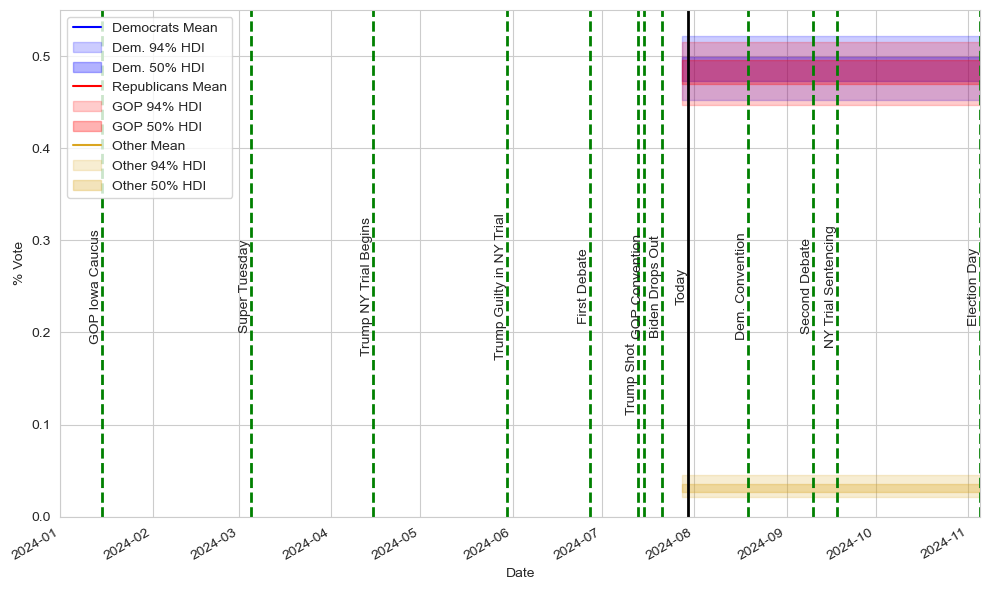

In [112]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_oth"].plot(color='goldenrod', label='Other Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].ffill(), df_day_97[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.2, label='Other 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].ffill(), df_day_75[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.3, label='Other 50% HDI')

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]
oth_votes = df.set_index('date').query(f"state == '{graph_state}'")["OTHER"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")
#ax.plot(oth_votes.index, oth_votes, "o", alpha=.5, markersize=3, color='goldenrod', label="Poll Other %")

# Set limits and labels
ax.set_ylim(0,.55)
ax.set_xlim(dt.datetime(2024, 1, 1), dt.datetime(2024, 11, 5))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            (dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            (dt.datetime(2024, 3,  5), 'Super Tuesday'),
            (dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            (dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'GOP Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            (dt.datetime(2024, 8, 19), 'Dem. Convention'),
            (dt.datetime(2024, 9, 10), 'Second Debate'),
            (dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            (dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.25, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
ax.axvline(x=dt.datetime(2024, 7, 13), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2024, 7, 13), 0.15, "Trump Shot", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.25, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/4201812920.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/4201812920.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, la

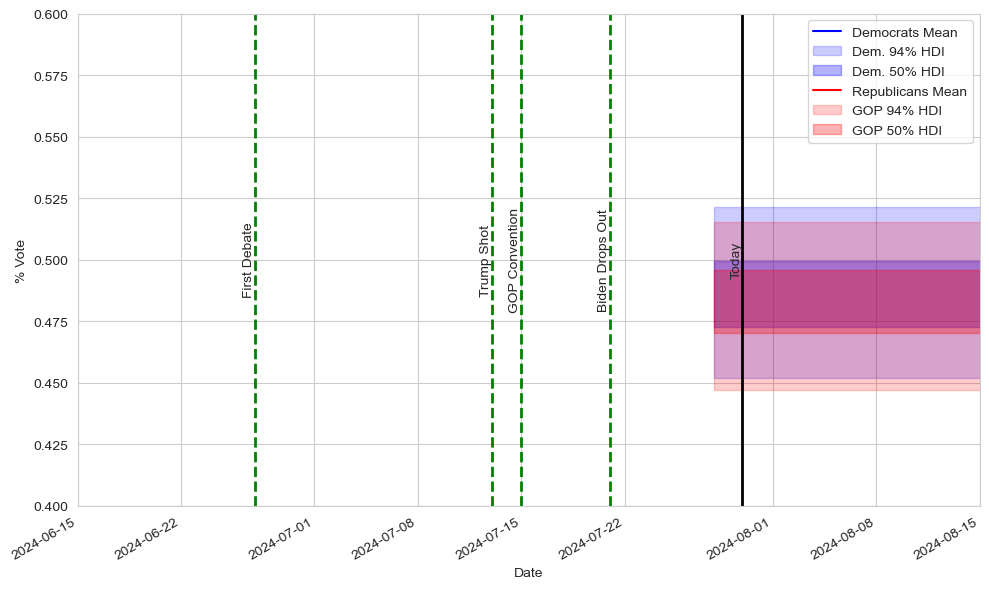

In [113]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

#df_day_mean[f"{graph_state}_oth"].plot(color='goldenrod', label='Other Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].ffill(), df_day_97[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.2, label='Other 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].ffill(), df_day_75[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.3, label='Other 50% HDI')

dem_votes = df.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df.set_index('date').query(f"state == '{graph_state}'")["GOP"]
oth_votes = df.set_index('date').query(f"state == '{graph_state}'")["OTHER"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")
#ax.plot(oth_votes.index, oth_votes, "o", alpha=.5, markersize=3, color='goldenrod', label="Poll Other %")

# Set limits and labels
ax.set_ylim(.4,.6)
ax.set_xlim(dt.datetime(2024, 6, 15), dt.datetime(2024, 8, 15))
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            #(dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            #(dt.datetime(2024, 3,  5), 'Super Tuesday'),
            #(dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            #(dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            (dt.datetime(2024, 6, 27), 'First Debate'),
            (dt.datetime(2024, 7, 15), 'GOP Convention'),
            (dt.datetime(2024, 7, 21), 'Biden Drops Out'),
            #(dt.datetime(2024, 8, 19), 'Dem. Convention'),
            #(dt.datetime(2024, 9, 10), 'Second Debate'),
            #(dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            #(dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.5, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
ax.axvline(x=dt.datetime(2024, 7, 13), color='green', linestyle='--', linewidth=2)
plt.text(dt.datetime(2024, 7, 13), 0.5, "Trump Shot", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.5, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

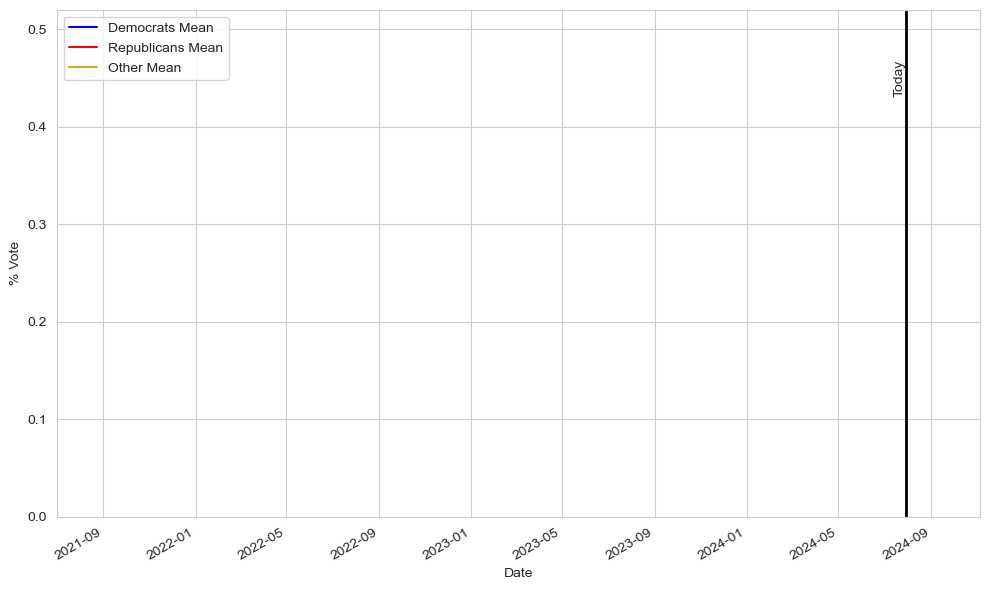

In [114]:
graph_state = 'US'

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting dem_votes and gop_votes on the same axes

df_day_mean[f"{graph_state}_dem"].plot(color='blue', label='Democrats Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_dem"].ffill(), df_day_97[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.2, label='Dem. 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_dem"].ffill(), df_day_75[f"{graph_state}_dem"].ffill(), color='blue', alpha=0.3, label='Dem. 50% HDI')

df_day_mean[f"{graph_state}_gop"].plot(color='red', label='Republicans Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_gop"].ffill(), df_day_97[f"{graph_state}_gop"].ffill(), color='red', alpha=0.2, label='GOP 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_gop"].ffill(), df_day_75[f"{graph_state}_gop"].ffill(), color='red', alpha=0.3, label='GOP 50% HDI')

df_day_mean[f"{graph_state}_oth"].plot(color='goldenrod', label='Other Mean')
#plt.fill_between(df_day_97.index, df_day_03[f"{graph_state}_oth"].ffill(), df_day_97[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.2, label='GOP 94% HDI')
#plt.fill_between(df_day_75.index, df_day_25[f"{graph_state}_oth"].ffill(), df_day_75[f"{graph_state}_oth"].ffill(), color='goldenrod', alpha=0.3, label='GOP 50% HDI')

dem_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["DEM"]
gop_votes = df_2way.set_index('date').query(f"state == '{graph_state}'")["GOP"]

#ax.plot(dem_votes.index, dem_votes, "o", alpha=.5, markersize=3, color='blue', label="Poll Dem., %")
#ax.plot(gop_votes.index, gop_votes, "o", alpha=.5, markersize=3, color='red', label="Poll GOP %")

# Set limits and labels
ax.set_ylim(0,0.52)
ax.set_xlim(dt.datetime(2021, 7, 1), dt.datetime(2024, 11, 5) #datetime.datetime.today()
           )
ax.set_ylabel('% Vote')
ax.set_xlabel('Date')
ax.legend()
#ax.set_title('2024 National Presidentential Polling')

events = [
            #(dt.datetime(2024, 1, 15), 'GOP Iowa Caucus'),
            #(dt.datetime(2024, 3,  5), 'Super Tuesday'),
            #(dt.datetime(2024, 4, 15), 'Trump NY Trial Begins'),
            #(dt.datetime(2024, 5, 30), 'Trump Guilty in NY Trial'),
            #(dt.datetime(2024, 6, 27), 'First Debate'),
            #(dt.datetime(2024, 7, 15), 'GOP Convention'),
            #(dt.datetime(2024, 8, 19), 'Dem. Convention'),
            #(dt.datetime(2024, 9, 10), 'Second Debate'),
            #(dt.datetime(2024, 9, 18), 'NY Trial Sentencing'),
            #(dt.datetime(2024, 11, 5), 'Election Day'),
         ]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=2)
    plt.text(date, 0.42, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)
    
#ax.axvline(x=datetime.datetime.today(), color='green', linestyle='-', linewidth=2)
#plt.text(dt.datetime(2024, 7, 13), 0.45, "Trump Assassination Attempt", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

ax.axvline(x=datetime.datetime.today(), color='black', linestyle='-', linewidth=2)
plt.text(datetime.datetime.today(), 0.45, "Today", rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

#ax.plot(dt.datetime(2020, 11, 3), .523, "o", markersize=25, color='blue', alpha=1)
#ax.plot(dt.datetime(2020, 11, 3), .477, "o", markersize=25, color='red', alpha=1)

plt.tight_layout()
plt.savefig('2way_enight_natpoll.png')

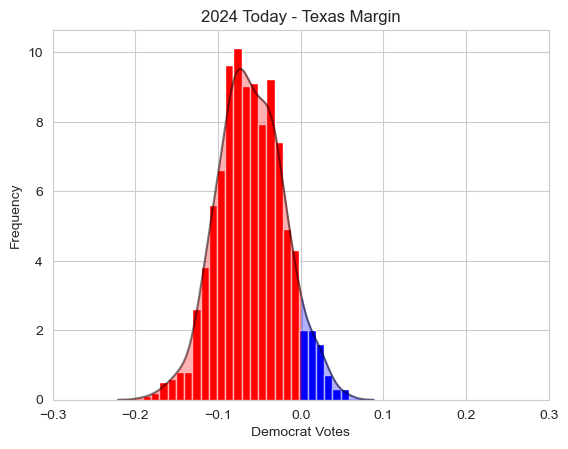

In [133]:
# TX, CA, MN, MI, FL, GA

graph_state = 'TX'

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_results[f"{graph_state}_margin"], binwidth=.01, kde=False, stat="density")

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() + 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 0:
        patch.set_facecolor('red')
    elif x > 0:
        patch.set_facecolor('blue')
    elif x == 0:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('green')

# Plot KDE
kde_ax = sns.kdeplot(df_results[f"{graph_state}_margin"], color='black', alpha = 0.5, ax=ax)

# Fill area above 270 with red color
kde_x, kde_y = kde_ax.get_lines()[0].get_data()
kde_ax.fill_between(kde_x, kde_y, where=(kde_x >= 0), color='blue', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x <= 0), color='red', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x == 0), color='lime', alpha=1)


# Adding titles and labels
plt.title('2024 Today - Texas Margin')
plt.xlabel('Democrat Votes')
plt.xlim(-.3, .3)
plt.ylabel('Frequency')

events = [
    #(13, 'Mondale 1984'),
    #(49, 'Carter 1980'),
    #(486, 'Johnson 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .05, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('2way_enight_tx.png')

In [116]:
df_winner = pd.DataFrame(columns=states)

for state in states:
    # Get values for the current state
    dem_votes = df_results[f"{state}_dem"]
    gop_votes = df_results[f"{state}_gop"]
    
    # Compare votes and determine winner
    df_winner[state] = pd.Series(
        ["dem" if dem_votes[i] > gop_votes[i]
         else "gop" if gop_votes[i] > dem_votes[i]
         else "tie"
         for i in range(len(df_results))]
    )

In [117]:
df_state['state_code'][~df_state['state_code'].isin(df_winner.columns)]

7       DE
30    NE-1
32    NE-3
56      DC
Name: state_code, dtype: object

In [118]:
#df_winner[['AR', 'ID', 'KS', 'KY', 'ME-2', 'MS', 'NE-1', 'NE-3', 'ND', 'WY']] = 'gop'
#df_winner[['CT', 'DE', 'IL','ME-1', 'NE-2', 'DC']] = 'dem'

#df_winner[['NE-1', 'NE-3']] = 'gop'
#df_winner[['DE','DC']] = 'dem'

df_winner['DE'] = df_winner['IL']
df_winner['NE-1'] = df_winner['KS']
df_winner['NE-3'] = df_winner['WY']
df_winner['DC'] = df_winner['VT']

state_order = df_state['state_code'].to_list

In [119]:
df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/586220177.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_dem = df_winner.replace({'dem': 1, 'gop': 0})
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_5054/586220177.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_winner_gop = df_winner.replace({'gop': 1, 'dem': 0})


In [120]:
df_ec = pd.DataFrame()
df_ec['dem'] = df_winner_dem.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)
df_ec['gop'] = df_winner_gop.mul(df_state[['state_code', 'electoral_2024']].set_index('state_code').T.iloc[0], axis=1).sum(axis=1)

In [121]:
# Calculate the total number of rows
total_rows = len(df_ec)

# Calculate the number of rows greater than, equal to, and lower than 270
greater_than_270 = len(df_ec[df_ec['dem'] > 269])
equal_to_270 = len(df_ec[df_ec['dem'] == 269])
lower_than_270 = len(df_ec[df_ec['dem'] < 269])

# Calculate the percentages
percent_greater_than_270 = (greater_than_270 / total_rows) * 100
percent_equal_to_270 = (equal_to_270 / total_rows) * 100
percent_lower_than_270 = (lower_than_270 / total_rows) * 100

percent_greater_than_270, percent_equal_to_270, percent_lower_than_270

(49.3, 0.7000000000000001, 50.0)

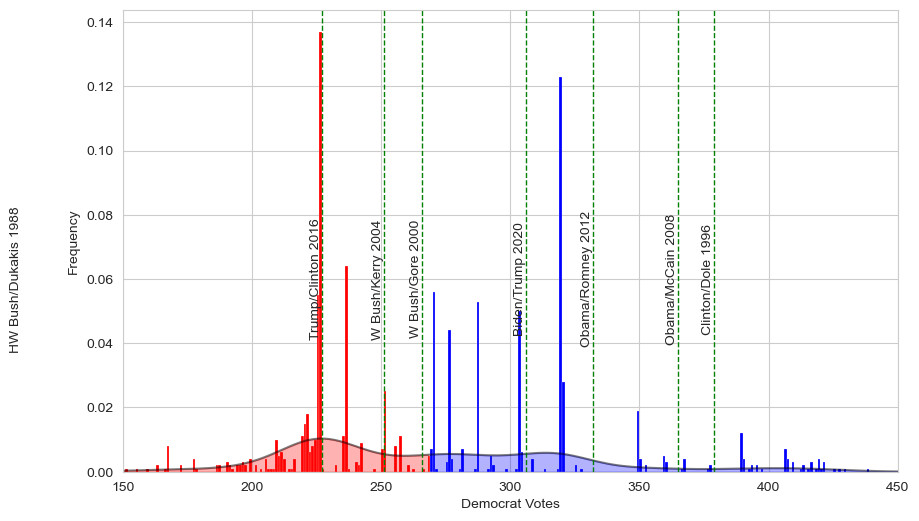

In [122]:

# Plotting the histograms
plt.figure(figsize=(10, 6))

# Use sns.histplot to plot the histogram
ax = sns.histplot(df_ec['dem'], binwidth=1, kde=False, stat="density")

# Get patches from the Axes
for patch in ax.patches:
    # Get x midpoint of bar
    x = patch.get_x() + 0.5 * patch.get_width()
    
    # Set bar color based on x
    if x < 269:
        patch.set_facecolor('red')
    elif x > 269:
        patch.set_facecolor('blue')
    elif x == 269:
        patch.set_facecolor('lime')
    else:
        patch.set_facecolor('green')

# Plot KDE
kde_ax = sns.kdeplot(df_ec['dem'], color='black', alpha = 0.5, ax=ax)

# Fill area above 270 with red color
kde_x, kde_y = kde_ax.get_lines()[0].get_data()
kde_ax.fill_between(kde_x, kde_y, where=kde_x > 269, color='blue', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=(kde_x < 269), color='red', alpha=0.3)
kde_ax.fill_between(kde_x, kde_y, where=kde_x == 269, color='lime', alpha=0.3)


# Adding titles and labels
#plt.title('2024 Election Night - Electoral College Results')
plt.xlabel('Democrat Votes')
plt.xlim(150, 450)
plt.ylabel('Frequency')

events = [
    #(13, 'Reagan/Mondale 1984'),
    #(49, 'Reagan/Carter 1980'),
    (111, 'HW Bush/Dukakis 1988'),
    (227, 'Trump/Clinton 2016'),
    (251, 'W Bush/Kerry 2004'),
    (266, 'W Bush/Gore 2000'),
    (306, 'Biden/Trump 2020'),
    (332, 'Obama/Romney 2012'),
    (365, 'Obama/McCain 2008'),
    (379, 'Clinton/Dole 1996'),
    #(486, 'Johnson/Goldwater 1964')
]

for date, event in events:
    ax.axvline(x=date, color='green', linestyle='--', linewidth=1)
    plt.text(date, .06, event, rotation=90, verticalalignment='center', horizontalalignment='right', fontsize=10)

# Display the plot
plt.savefig('2way_enight_ec.png')

In [123]:
df_margin = pd.DataFrame(columns=states)
df_gop = pd.DataFrame(columns=states)
df_dem = pd.DataFrame(columns=states)
df_oth = pd.DataFrame(columns=states)

for state in states:
    df_margin[state] = df_results[f"{state}_margin"]
    df_gop[state] = df_results[f"{state}_gop"]
    df_dem[state] = df_results[f"{state}_dem"]
    df_oth[state] = df_results[f"{state}_oth"]

df_mean = pd.DataFrame(columns=parties)
df_mean['dem'] = df_dem.mean()
df_mean['gop'] = df_gop.mean()
df_mean['oth'] = df_oth.mean()
df_mean['margin'] = df_margin.mean()

In [124]:
df_win_pct = pd.DataFrame()
df_win_pct['dem'] = df_winner_dem.mean(axis=0)
df_win_pct['gop'] = df_winner_gop.mean(axis=0)

In [125]:
df_win_pct.sort_values('dem')

,dem,gop
UT,0.000,1.000
NE-3,0.000,1.000
TN,0.000,1.000
MO,0.000,1.000
OK,0.000,1.000
MT,0.000,1.000
IN,0.000,1.000
AL,0.000,1.000
NE,0.000,1.000
WV,0.000,1.000


In [126]:
df_mean.sort_values('margin')

,dem,gop,margin,oth
WY,0.306454,0.668841,-0.362387,0.024705
OK,0.353979,0.614455,-0.260476,0.031567
ND,0.355920,0.598527,-0.242607,0.045554
WV,0.367455,0.600478,-0.233023,0.032067
AR,0.374576,0.599599,-0.225023,0.025825
KY,0.376466,0.596246,-0.219780,0.027288
ID,0.385721,0.585418,-0.199697,0.028861
SD,0.388252,0.577930,-0.189678,0.033818
AL,0.394473,0.583363,-0.188890,0.022164
UT,0.379897,0.564812,-0.184915,0.055291


In [127]:
df_day_mean.US_dem.tail(110).head(20)

date
2024-07-18         NaN
2024-07-20         NaN
2024-07-21         NaN
2024-07-22         NaN
2024-07-23         NaN
2024-07-24         NaN
2024-07-25         NaN
2024-07-26         NaN
2024-07-27         NaN
2024-07-28    0.484971
2024-07-29         NaN
2024-07-30         NaN
2024-07-31         NaN
2024-08-01         NaN
2024-08-02         NaN
2024-08-03         NaN
2024-08-04         NaN
2024-08-05         NaN
2024-08-06         NaN
2024-08-07         NaN
Name: US_dem, dtype: object